 Importing Libraries and Dependencies

In [1]:
# Importing necessary packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=224, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--epochs', default=10, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="model_plot.png", help="Path to save model's plot")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

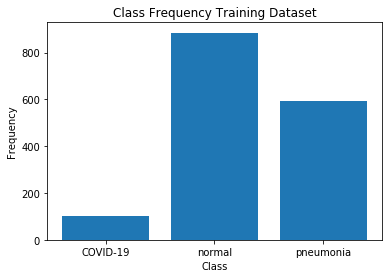

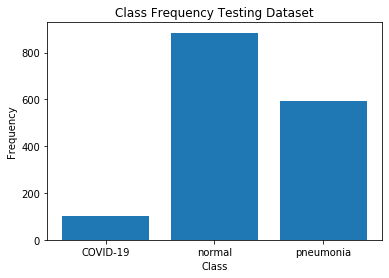

In [3]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Instantiating data generators to load datasets

In [4]:
# Initialising data augmentation object to improve the dataset
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    os.path.join(args.data_dir, args.train_data_dir),
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=BS,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=14
)

validation_generator = train_data_gen.flow_from_directory(
    os.path.join(args.data_dir,args.train_data_dir),
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=BS,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=14
)

test_generator = test_data_gen.flow_from_directory(
    os.path.join(args.data_dir,args.test_data_dir),
    target_size=(args.input_size, args.input_size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 11141 images belonging to 3 classes.
Found 2784 images belonging to 3 classes.
Found 1579 images belonging to 3 classes.


Creating the model

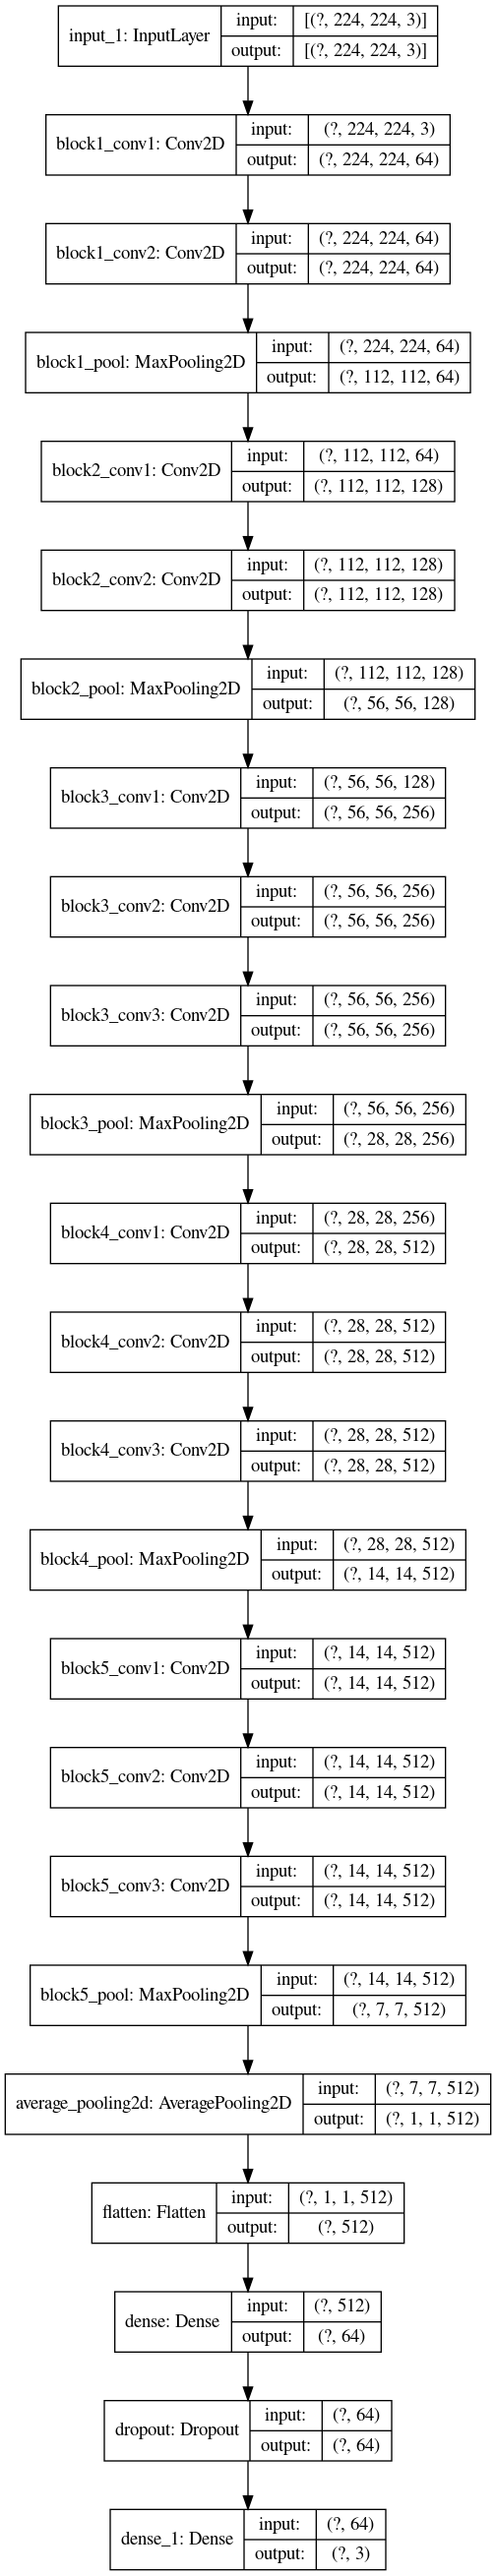

In [5]:
# Loading VGG16 model trained on imagenet without head
baseModel = VGG16(
    weights="imagenet", include_top=False,
    input_tensor=Input(shape=(args.input_size, args.input_size,
                              args.n_channels))
)

# Constructing the head for classification (to be trained)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# Fixing the weights of base model
for layer in baseModel.layers:
	layer.trainable = False

# Saving a plot of the model
plot_model(model, to_file=args.model_plot, show_shapes=True, show_layer_names=True)

Training the model

In [6]:
# Compiling the model
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

# Calculating class weights since COVID-19 data is very less
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes,
                                                  train_labels)
# Formatting class weights for keras
class_idx = train_generator.class_indices
cw = {}
for i in range(0, 3):
    cw.update({class_idx.get(classes[i]): class_weights[i]})
class_weights = cw

# Training model
print("[INFO] Training model")
H = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BS,
    epochs=EPOCHS,
    class_weight=class_weights)

[INFO] Training model
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1392 steps, validate for 348 steps
Epoch 1/10
1392/1392 [==============================] - 201s 144ms/step - loss: 0.9885 - accuracy: 0.5986 - val_loss: 0.8675 - val_accuracy: 0.6879
Epoch 2/10
1392/1392 [==============================] - 160s 115ms/step - loss: 0.8311 - accuracy: 0.6960 - val_loss: 0.7731 - val_accuracy: 0.7784
Epoch 3/10
1392/1392 [==============================] - 157s 113ms/step - loss: 0.7625 - accuracy: 0.7256 - val_loss: 0.7149 - val_accuracy: 0.7874
Epoch 4/10
1392/1392 [==============================] - 159s 115ms/step - loss: 0.7221 - accuracy: 0.7359 - val_loss: 0.6796 - val_accuracy: 0.7953
Epoch 5/10
1392/1392 [==============================] - 161s 115ms/step - loss: 0.6868 - accuracy: 0.7498 - val_loss: 0.6429 - val_accuracy: 0.7877
Epoch 6/10
1392/1392 [==============================] - 159s 114ms/

Evaluating the model and generating predictions

In [7]:
# Evaluating model on training data
print("[INFO] Evaluating model on training data")
model.evaluate_generator(generator=validation_generator,
                         steps=validation_generator.samples // BS)

# Predicting on testing data
print("[INFO] Predicting on testing data")
test_file_names = test_generator.filenames
nb_samples = len(test_file_names)
test_generator.reset()
pred = model.predict_generator(test_generator, steps=nb_samples, verbose=1)
pred = np.argmax(pred, axis=1)

# Getting class label map
label_map = (test_generator.class_indices)
for c in classes:
    label_map.update({label_map.get(c): c})
    label_map.pop(label_map.get(label_map.get(c)))
temp = []
for i in range(len(label_map)):
    temp.append(label_map.get(i))
label_map = temp
del(temp)

# Printing classification report
print(classification_report(test_generator.classes, pred, target_names=label_map))

[INFO] Evaluating model on training data
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
[INFO] Predicting on testing data
Instructions for updating:
Please use Model.predict, which supports generators.
1579/1579 [==============================] - 41s 26ms/step
              precision    recall  f1-score   support

    COVID-19       0.31      0.70      0.43       100
      normal       0.92      0.83      0.87       885
   pneumonia       0.81      0.75      0.78       594

   micro avg       0.79      0.79      0.79      1579
   macro avg       0.68      0.76      0.69      1579
weighted avg       0.84      0.79      0.81      1579



Printing confusion matrix

In [8]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(test_generator.classes, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

[[ 70   9  21]
 [ 62 737  86]
 [ 91  58 445]]
Overall Accuracy: 0.7929
COVID Sensitivity: 0.7000
COVID Specificity: 0.8966


Plotting the training performance

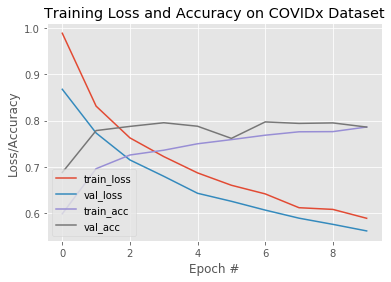

In [9]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
args.plot = "plot_vgg16_sgd.png"
plt.savefig(args.plot)